# Update log:
1. merged few cells
2. change center_crop = 300 to center_crop = 500 (if cutting at 300, we can't see mask for people wearing mask inappropriately )
3. added grid show to dispaly a random batch



In [1]:
import numpy as np 
import pandas as pd
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
import torch.nn as nn
from torch.nn import Dropout
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
from tqdm.notebook import tqdm

In [4]:
from pathlib import Path

In [5]:
from os.path import dirname, abspath

In [6]:
d = dirname(dirname(dirname(dirname(dirname(dirname(dirname(dirname(abspath("loading_dataset.ipynb")))))))))

In [7]:
os.chdir(d + "/MaskedFace-Net")

In [8]:
#Define transformation for train and validation dataset
transform_train = transforms.Compose(
    [transforms.RandomRotation(20),
     transforms.RandomHorizontalFlip(0.5),
     transforms.CenterCrop(500),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_val = transforms.Compose(
    [transforms.CenterCrop(500),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [9]:
#load trian, val, and test images from data folder
maskedface_net_train = torchvision.datasets.ImageFolder("../MaskedFace-Net/train", transform=transform_train)
maskedface_net_val = torchvision.datasets.ImageFolder("../MaskedFace-Net/validation", transform=transform_val)
maskedface_net_test = torchvision.datasets.ImageFolder("../MaskedFace-Net/holdout", transform=transform_val)

data_loader_train = torch.utils.data.DataLoader(maskedface_net_train,
                                          batch_size=4,
                                          shuffle=True)

data_loader_val = torch.utils.data.DataLoader(maskedface_net_val,
                                             batch_size=4,
                                             shuffle=True)

data_loader_test = torch.utils.data.DataLoader(maskedface_net_test,
                                             batch_size=4,
                                             shuffle=True)

In [10]:
#displays images
# label 2 - not wearing mask
# label 1 - wearing mask but not appropriately
# label 0 - wearing mask appropriately
data_iter = iter(data_loader_train).next()
img, label = data_iter
print(label)

tensor([0, 1, 1, 2])


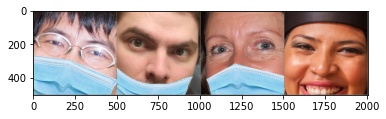

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(img))

In [40]:
device = torch.device("cuda")

In [41]:
def get_resnet():
    input_img = Input((4, 4, 300,28),name='input_layer')
    zeroPad1 = ZeroPadding2D((1,1), name='zeroPad1', dim_ordering='th')
    zeroPad1_2 = ZeroPadding2D((1,1), name='zeroPad1_2', dim_ordering='th')
    layer1 = Convolution2D(6, 3, 3, subsample=(2, 2), init='he_uniform', name='major_conv', dim_ordering='th')
    layer1_2 = Convolution2D(16, 3, 3, subsample=(2, 2), init='he_uniform', name='major_conv2', dim_ordering='th')
    zeroPad2 = ZeroPadding2D((1,1), name='zeroPad2', dim_ordering='th')
    zeroPad2_2 = ZeroPadding2D((1,1), name='zeroPad2_2', dim_ordering='th')
    layer2 = Convolution2D(6, 3, 3, subsample=(1,1), init='he_uniform', name='l1_conv', dim_ordering='th')
    layer2_2 = Convolution2D(16, 3, 3, subsample=(1,1), init='he_uniform', name='l1_conv2', dim_ordering='th')
    zeroPad3 = ZeroPadding2D((1,1), name='zeroPad3', dim_ordering='th')
    zeroPad3_2 = ZeroPadding2D((1,1), name='zeroPad3_2', dim_ordering='th')
    layer3 = Convolution2D(6, 3, 3, subsample=(1, 1), init='he_uniform', name='l2_conv', dim_ordering='th')
    layer3_2 = Convolution2D(16, 3, 3, subsample=(1, 1), init='he_uniform', name='l2_conv2', dim_ordering='th')
    layer4 = Dense(64, activation='relu', init='he_uniform', name='dense1')
    layer5 = Dense(16, activation='relu', init='he_uniform', name='dense2')
    final = Dense(10, activation='softmax', init='he_uniform', name='classifier')
    
    sgd = SGD(decay=0., lr=0.01, momentum=0.9, nesterov=True)
    model.compile(loss=scc, optimizer=sgd, metrics=['accuracy'])
    return model

## Models

In [42]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [43]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        model_ft = models.resnet18(pretrained=True)
        set_parameter_requires_grad(model_ft, True)
        self.features = nn.Sequential(
            *list(model_ft.children())[:6]
        )
        self.conv1 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
        self.bh1 = nn.BatchNorm2d(num_features = 128)
        self.bh2 = nn.BatchNorm2d(num_features = 64)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.dropout = Dropout(p = 0.5)
        self.bh3 = nn.BatchNorm1d(num_features = 500)
        self.lin1 = nn.Linear(in_features = 2304, out_features =500)
        self.lin2 = nn.Linear(in_features = 500, out_features = 1)

    def forward(self, x):
        x = self.features(x)
        x = self.bh1(F.relu(self.conv1(x)))
        x = self.maxpool(x)
        x = self.bh1(F.relu(self.conv2(x)))
        x = self.bh2(F.relu(self.conv3(x)))
        x = self.bh2(F.relu(self.conv4(x)))
        x = self.maxpool(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.dropout(x)
        x = self.bh3(F.relu(self.lin1(x)))
        x = self.lin2(x)  
        return x

In [44]:
model = CNN()

In [45]:
model

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Training

In [46]:
def training(num_epochs, model, optimizer, criterion, train_loader, validation_loader, batch_size, device, save_path):
    train_acc_lst = []
    train_loss_lst = []
    val_acc_lst = []
    val_loss_lst = []
    val_min_loss = np.inf
    
    model = model.double().to(device)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        train_loss = 0.0
        val_loss = 0.0

    #training step(we only update the model in the training loop)
        for i, data in enumerate(tqdm(train_loader), 0):
            train_inputs, train_labels = data
            train_inputs, train_labels = train_inputs.double().to(device), train_labels.double().view(-1, 1).to(device)

            optimizer.zero_grad()

            train_outputs = model(train_inputs)
            loss = criterion(train_outputs, train_labels)
            loss.backward()
            optimizer.step()

            #calculate training loss
            train_loss += loss.item() * train_inputs.size(0)

        model.eval()

        for i, data in enumerate(tqdm(validation_loader), 0):
            val_inputs, val_labels = data
            val_inputs, val_labels = val_inputs.double().to(device), val_labels.double().view(-1, 1).to(device)

            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item() * val_inputs.size(0)

        avg_train_loss = train_loss / (len(train_loader) * batch_size)
        train_acc = (torch.sigmoid(train_outputs).squeeze().round() == train_labels.squeeze()).cpu().numpy().mean()

        avg_val_loss = val_loss / (len(validation_loader) * batch_size)
        val_acc = (torch.sigmoid(val_outputs).squeeze().round() == val_labels.squeeze()).cpu().numpy().mean()


        print("Epoch: {}/{}...".format(epoch+1, num_epochs),
              "train Loss: {:.6f}...".format(avg_train_loss),
              "train accurcy: {:.2f}...".format(train_acc),
              "val Loss: {:.6f}".format(avg_val_loss),
              "val accurcy: {:.2f}...".format(val_acc))

        train_loss_lst.append(avg_train_loss)
        train_acc_lst.append(round(train_acc, 2))
        val_loss_lst.append(avg_val_loss)
        val_acc_lst.append(round(val_acc, 2))

        if avg_val_loss <= val_min_loss:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            val_min_loss,
            avg_val_loss))
            torch.save(model.state_dict(), save_path)
            val_min_loss = avg_val_loss


        model.train()
    
    return train_acc_lst, train_loss_lst, val_acc_lst, val_loss_lst

In [47]:
model.parameters()

<generator object Module.parameters at 0x7f54e199d550>

In [48]:
num_epochs = 20
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train_loader = data_loader_train
validation_loader = data_loader_val
save_path = 'model.pt'
batch_size = 4

In [49]:
training(num_epochs, model, optimizer, criterion, train_loader, validation_loader, batch_size, device, save_path)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [4]:
print("Is CUDA available? ",torch.cuda.is_available())

Is CUDA available?  False


/datasets/home/22/122/atl074/.local/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [1]:
! pip install torch===1.7.1 torchvision===0.8.2 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached torchvision-0.8.2-cp37-cp37m-manylinux1_x86_64.whl (12.8 MB)
  Using cached torchaudio-0.7.2-cp37-cp37m-manylinux1_x86_64.whl (7.6 MB)
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
